---

# Lib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MultiLabelBinarizer

from utils.other import parse_label

---

# Read file

In [2]:
df = pd.read_csv("../data/raw/train.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [3]:
df.head()

,brand,model,version,year,segment,comment,label
0,huyndai,accent,NaN,2024,sedan,Đuôi dạng coupe nhìn đẹp hẳn.,{EXTERIOR#Positive};
1,huyndai,accent,NaN,2024,sedan,đèn trước quá xấu,{EXTERIOR#Negative};
2,toyota,yaris cross,máy xăng,2024,suv,YC xăng: nội thất mình thấy OK hơn XForce. Chạ...,{EXTERIOR#Positive};{PERFORMANCE#Negative};{IN...
3,nissan,almera,NaN,2025,sedan,Mình đang đi được 3 năm rất hài lòng . Rất bốc...,{PERFORMANCE#Positive};{COST#Positive};
4,omoda,c5,NaN,2024,suv,Nhìn cái bệ tì tay với cái màn hình là kết rồ...,{INTERIOR#Positive};


---

# EDA

In [4]:
print(f"{df.shape[0]} rows")
print(f"{df.shape[1]} columns")

1403 rows
7 columns


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    1403 non-null   object
 1   model    1403 non-null   object
 2   version  461 non-null    object
 3   year     1403 non-null   int64 
 4   segment  1403 non-null   object
 5   comment  1403 non-null   object
 6   label    1403 non-null   object
dtypes: int64(1), object(6)
memory usage: 76.9+ KB


## Missing values

Sự null này là MNAR (Missing not a random) tức version được thiếu vì:
- video, người đánh giá không đề cập rõ về version cụ thể của xe mà đánh giá chung về model xe đó hoặc các loại xe.
- Không quá khác biệt về thiết kế nột thất hoặc ngoại thất mà có thể là sự khác biệt về động cơ hoặc các tính năng, công nghệ được trang bị.
- Xe chỉ có duy nhất 1 version được bán ra thị trường với tên brand + model

In [6]:
df.isnull().sum()

brand        0
model        0
version    942
year         0
segment      0
comment      0
label        0
dtype: int64

## Categorical columns

In [7]:
for col in df.columns[:-2]:
    num_unique_values = df[col].nunique()
    print(f"{col}: {num_unique_values} unique values")

brand: 10 unique values
model: 15 unique values
version: 9 unique values
year: 2 unique values
segment: 2 unique values


In [8]:
for col in df.columns[:-2]:
    print(f"{col}: {df[col].unique()}")
    print()

brand: ['huyndai' 'toyota' 'nissan' 'omoda' 'byd' 'kia' 'honda' 'hyundai' 'mazda'
 'mitsubishi']

model: ['accent' 'yaris cross' 'almera' 'c5' 'sealion 6' 'seltos' 'atto 2' 'hr-v'
 'creta' '2' 'vios' 'seal 5' 'atto 3' 'xforce' 'soluto']

version: [nan 'máy xăng' 'g' 'n line' 'at' 'l' 'dm-i' 'facelift' 'ultimate' 'e']

year: [2024 2025]

segment: ['sedan' 'suv']



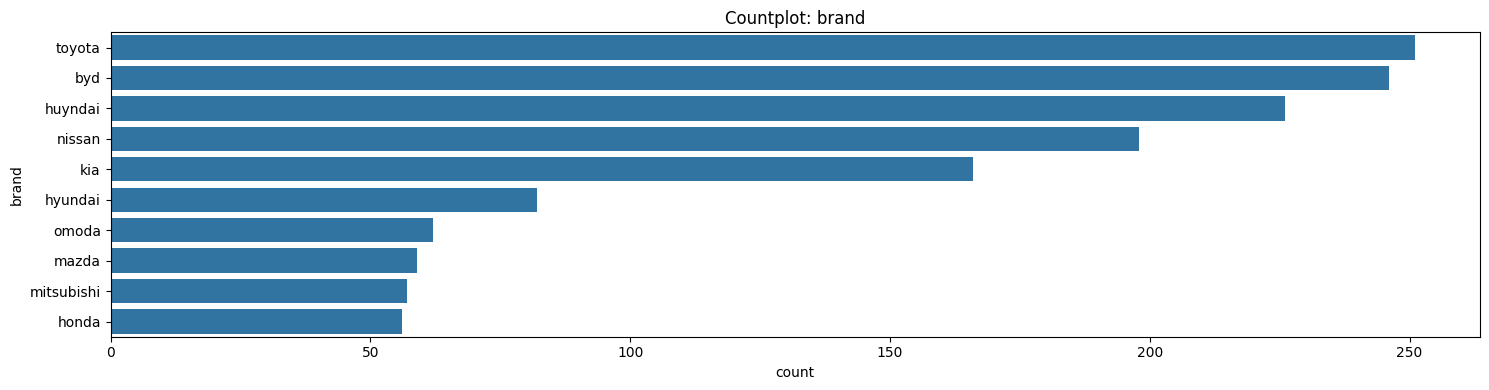

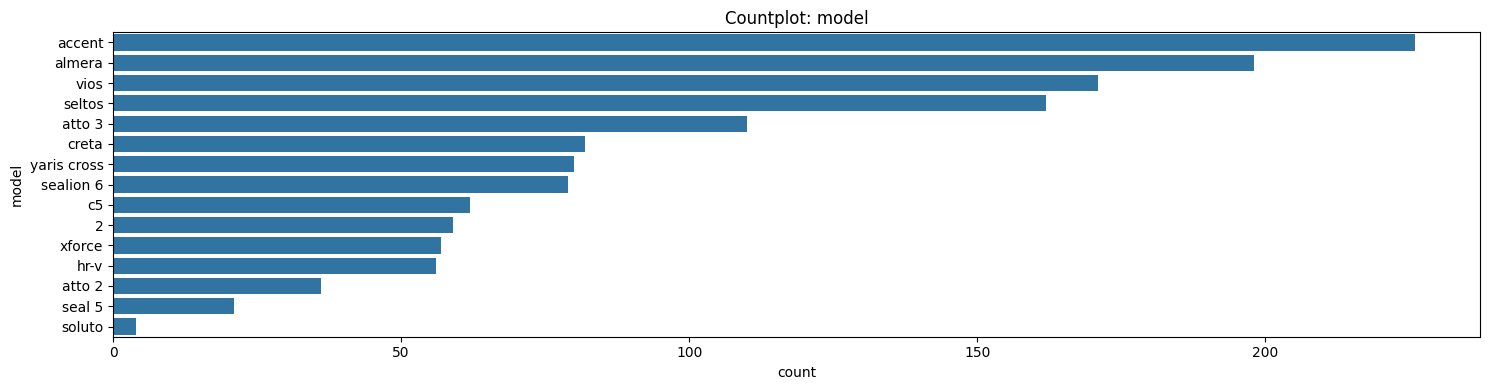

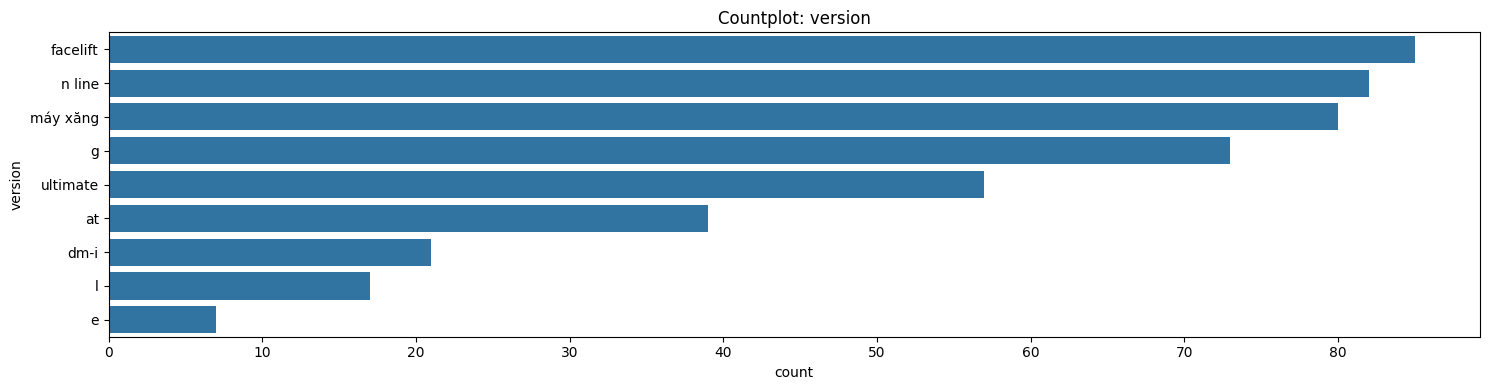

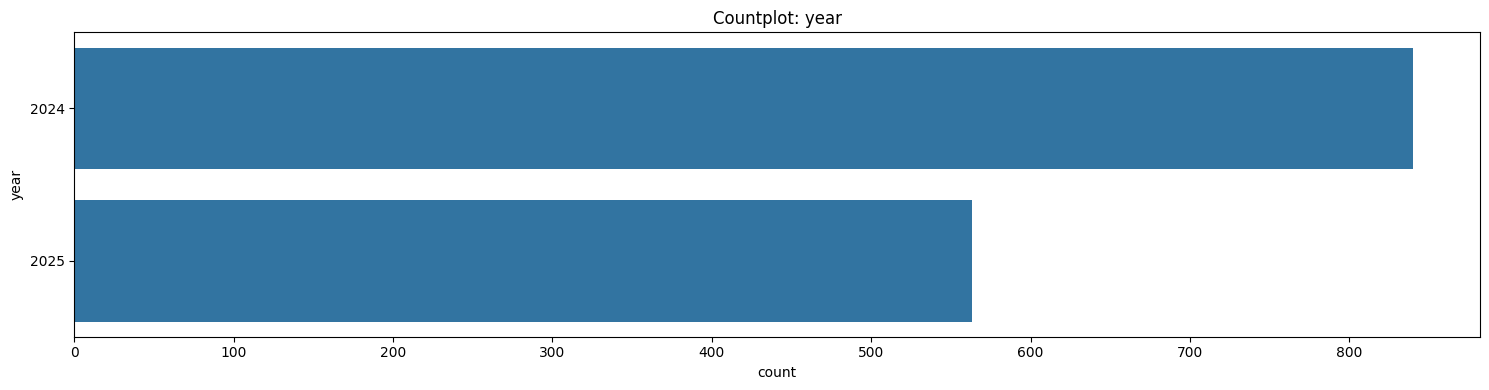

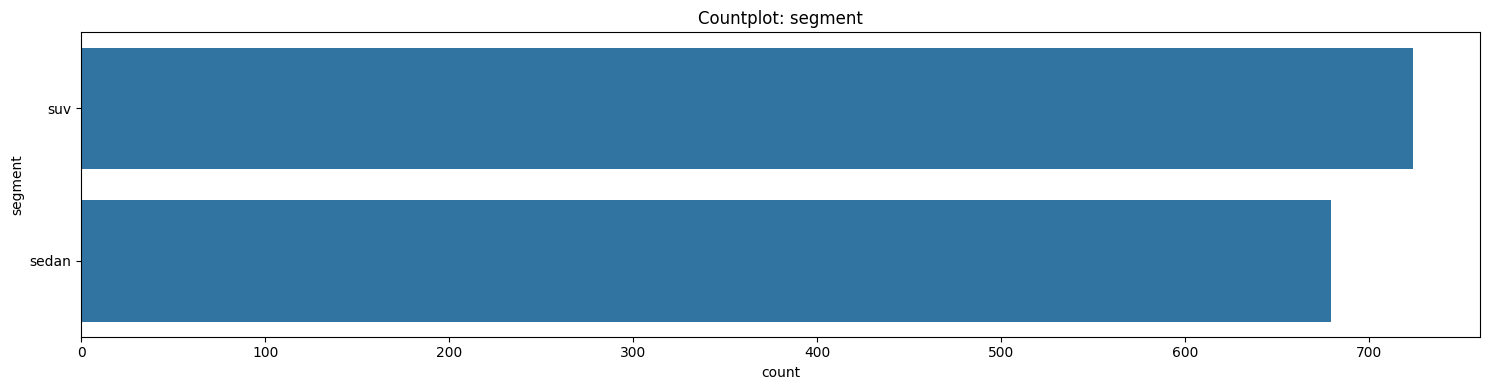

In [9]:
for col in df.columns[:-2]:
    counts = df[col].value_counts()
    plt.figure(figsize=(15, 4))
    sns.countplot(y=col, data=df, order=counts.index)
    plt.title(f"Countplot: {col}")
    plt.tight_layout()
    plt.show()

---

# Labels

In [10]:
df_label = df[["comment", "label"]].copy()

In [11]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  1403 non-null   object
 1   label    1403 non-null   object
dtypes: object(2)
memory usage: 22.0+ KB


In [12]:
df_label.head()

,comment,label
0,Đuôi dạng coupe nhìn đẹp hẳn.,{EXTERIOR#Positive};
1,đèn trước quá xấu,{EXTERIOR#Negative};
2,YC xăng: nội thất mình thấy OK hơn XForce. Chạ...,{EXTERIOR#Positive};{PERFORMANCE#Negative};{IN...
3,Mình đang đi được 3 năm rất hài lòng . Rất bốc...,{PERFORMANCE#Positive};{COST#Positive};
4,Nhìn cái bệ tì tay với cái màn hình là kết rồ...,{INTERIOR#Positive};


## Parsed label

In [13]:
df_label["parsed_labels"] = df_label["label"].apply(parse_label)

In [14]:
print(df_label['parsed_labels'].head())
print()
print(df_label['parsed_labels'].iloc[0])

0                                  [EXTERIOR#Positive]
1                                  [EXTERIOR#Negative]
2    [EXTERIOR#Positive, PERFORMANCE#Negative, INTE...
3                [PERFORMANCE#Positive, COST#Positive]
4                                  [INTERIOR#Positive]
Name: parsed_labels, dtype: object

['EXTERIOR#Positive']


## Create binary matrix for multi-label classification

In [15]:
# Use MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [16]:
# Binary matrix for multi-label classification
matrix_label = mlb.fit_transform(df_label['parsed_labels'])

In [17]:
y = pd.DataFrame(matrix_label, columns=mlb.classes_)
y.head()

,BRAND#Negative,BRAND#Neutral,BRAND#Positive,COST#Negative,COST#Neutral,COST#Positive,EXTERIOR#Negative,EXTERIOR#Neutral,EXTERIOR#Positive,FEATURES#Negative,FEATURES#Neutral,FEATURES#Positive,INTERIOR#Negative,INTERIOR#Neutral,INTERIOR#Positive,PERFORMANCE#Negative,PERFORMANCE#Neutral,PERFORMANCE#Positive
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [18]:
label_counts = y.sum(axis=0).sort_values(ascending=False)
total_labels = int(y.values.sum())

In [19]:
print(f"Total labels: {total_labels}")

Total labels: 2122


In [20]:
print(f"Unique labels: {mlb.classes_}")

Unique labels: ['BRAND#Negative' 'BRAND#Neutral' 'BRAND#Positive' 'COST#Negative'
 'COST#Neutral' 'COST#Positive' 'EXTERIOR#Negative' 'EXTERIOR#Neutral'
 'EXTERIOR#Positive' 'FEATURES#Negative' 'FEATURES#Neutral'
 'FEATURES#Positive' 'INTERIOR#Negative' 'INTERIOR#Neutral'
 'INTERIOR#Positive' 'PERFORMANCE#Negative' 'PERFORMANCE#Neutral'
 'PERFORMANCE#Positive']


In [21]:
label_counts

EXTERIOR#Positive       303
PERFORMANCE#Positive    189
EXTERIOR#Negative       188
BRAND#Positive          184
COST#Negative           174
COST#Positive           169
INTERIOR#Positive       166
BRAND#Negative          158
FEATURES#Negative       124
PERFORMANCE#Negative    119
FEATURES#Positive       105
INTERIOR#Negative        96
BRAND#Neutral            45
EXTERIOR#Neutral         37
FEATURES#Neutral         25
COST#Neutral             14
INTERIOR#Neutral         14
PERFORMANCE#Neutral      12
dtype: int64

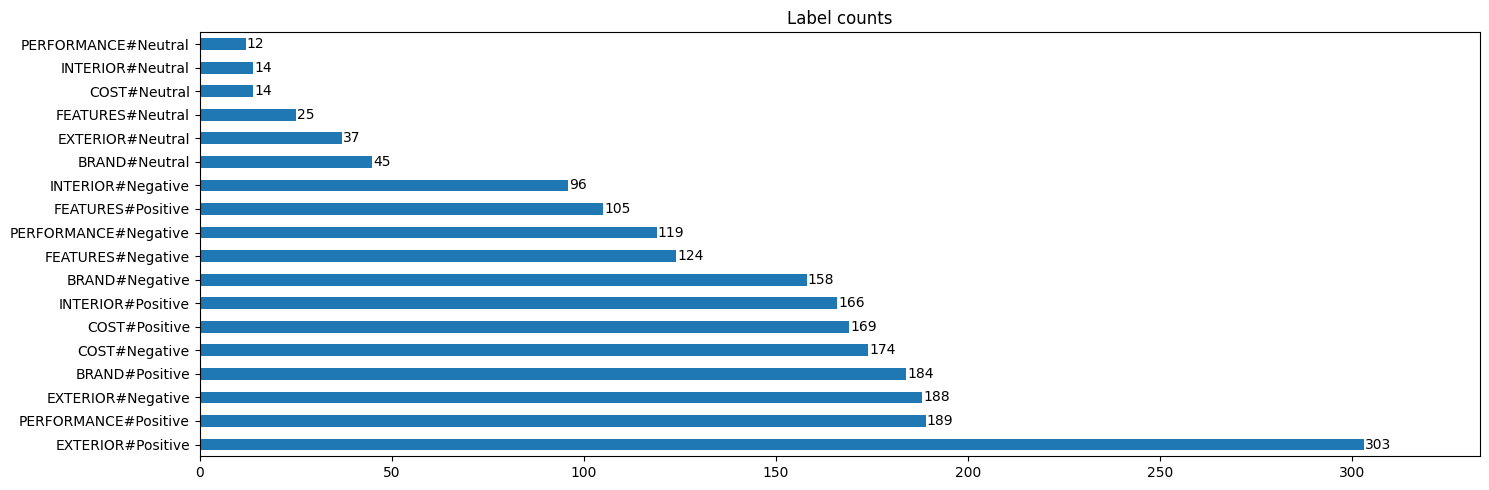

In [30]:
ax = label_counts.plot(kind='barh', figsize=(15,5), title='Label counts')
max_width = int(label_counts.max())
for p in ax.patches:
    value = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    x = p.get_x() + p.get_width() + 0.3
    ax.text(x, y, str(value), va='center', ha='left', fontsize=10)
ax.set_xlim(0, max_width * 1.10) 
plt.tight_layout()
plt.show()